In [2]:
# import packages
import numpy as np
# import scipy.integrate as integrate
# from sympy import *
import time

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.animation as animation

from matplotlib import cm
from matplotlib.ticker import LinearLocator
## set default plot size
plt.rcParams["figure.figsize"] = (10, 7)
## set global font size
plt.rcParams.update({'font.size':14})

# import astropy.units as u
from astropy import constants as const

from scipy.interpolate import interp1d


# Sampling Particle Trajectories

This notebook focuses on computing and animating the trajectories of individual particles within our two-hammer potential rather than the full solution $\delta f$. I will do this by using the analytical solution to Hamilton's equations, assuming two delta-function perturbations. (In `Leapfrogging Particle Trajectories.ipynb`, I will instead numerically solve Hamilton's equations, which won't necessarily assume delta-function perturbations.)

# Isothermal Slab Dynamics

First, we'll directly plot the motions of individual stars within a two-hammer, isothermal slab potential. The analytical (dimensionless) solutions to Hamilton's equations are:

$$ \theta(\tilde{t}) = \theta_0 + \int_0^{\tilde{t}} d\tilde{t}' \Omega(\tilde{J}(\tilde{t}')) $$
   $$ \tilde{J}(\tilde{t}) = \tilde{J}_0 + n_1 \tilde{A}_1 \sin(n_1\theta(\tilde{t}_1)) H(\tilde{t}-\tilde{t}_1) + n_2 \tilde{A}_2 \sin(n_2 \theta(\tilde{t}_2)) H(\tilde{t}-\tilde{t}_2) $$
   
where $\tilde{\Omega}$ is:

$$ \tilde{\Omega}(\tilde{J}) = \frac{1}{\sqrt{2}} \left[1+\frac{3\sqrt{2}}{\pi^2}\tilde{J}\right]^{-1/3}. $$

## Drawing from an arbitrary random distribution

Source: https://stackoverflow.com/a/64288861

In [3]:
def inverse_sample_decorator(dist):
    
    # for now, set our maximum J to 40
    def wrapper(pnts, x_min=0, x_max=40, n=1e5, **kwargs):
        
        x = np.linspace(x_min, x_max, int(n))
        cumulative = np.cumsum(dist(x, **kwargs))
        cumulative -= cumulative.min()
        f = interp1d(cumulative/cumulative.max(), x)
        return f(np.random.random(pnts))
    
    return wrapper

# example distribution
# @inverse_sample_decorator
# def gauss(x, amp=1.0, mean=0.0, std=0.2):
#     return amp*np.exp(-(x-mean)**2/std**2/2.0)

In [4]:
## define the slab Omega, Hamiltonian, and f0(J)

def compute_Omega(J):
    '''
    Represents (dimensionless) Omega(J). We use Omega = a/(1 + b*J)^(1/3)
    
    '''
    
    a = 1. / np.sqrt(2)
    b = 3 * np.sqrt(2) / pow(np.pi,2)

    return a * pow(1 + b*J, -1/3)

def Hamiltonian(J):
    '''
    Computes the Hamiltonian of our system by integrating Omega(J)
    from 0 to J. (Underneath Eq. 8 in Scott's paper, it's stated that
    Omega = dH/dJ.) We assume that Omega=0 for H=0.
    
    We use Omega = a/(1 + b*J)^(1/3) and its analytical antiderivative.
    
    '''
    
    term1 = np.pi**2 / 4
    b = 3*np.sqrt(2) / (np.pi**2)
    
    term2 = (1 + b*J)**(2/3)
    return term1 * term2


def f_0(J): 
    '''
    Initial distribution function of our system, using Eq. 6 of Scott's
    paper.
    
    '''
    
    return np.exp(-1*Hamiltonian(J)) / np.sqrt(2 * np.pi)

@inverse_sample_decorator
def f_0_distro(J): 
    '''
    The version of f_0(J) we use to perform inverse transform sampling.
    
    '''
    
    return np.exp(-1*Hamiltonian(J)) / np.sqrt(2 * np.pi)

## Outline

Let N be the number of particles I'm simulating. (I should test N=1, 10, 100, ...). Our plan is:

1. Keep two N-length arrays, one representing the $\theta$'s of all the particles and one representing all the $J$'s at a certain timepoint $t_i$.
2. Keep an array with timepoints, e.g., `ts = np.arange(0, 300, 0.5)`.
3. Set the initial conditions. Each $J_0$ should be in $(0, 20)$, while each $\theta_0$ should be in $[0, 2\pi)$.
4. Update $\theta$ at every timestep. Update $J$ and $\Omega(J)$ iff there's a hammer.

In [36]:
## define hammer params, phase space range

# define the parameters of the two hammers (t_i, n_i, A_i)
t1, t2 = 0, 100
n1, n2 = 1, 3
A1, A2 = 0.1, 0.2

# define ts, thetas, and Js; and, corresponding Cartesian coords
N = (int) (1e5) # number of particles

# time range
tmin = 0
tmax = 20
tstep = 0.5
ts = np.arange(tmin, tmax+tstep, tstep)

# Monte Carlo sample our initial conditions
np.random.seed(2)
thetas = (2*np.pi) *np.random.rand(N)
Js = f_0_distro(N) # drawn from f_0(J)

# initial Omega values
Omegas = compute_Omega(Js)

In [5]:
# ## check that sampling method is consistent with underlying distro

# Js_temp = np.arange(0, 20, 1e-2)

# # sampled J's
# num_bins = 20
# bins = np.linspace(0, np.max(Js), num=num_bins)
# hist = plt.hist(Js, bins=bins, label="sampled data", density=True)

# ## distribution function
# J_axis = (hist[1][:-1] + hist[1][1:]) / 2 # midpoints of histogram bins
# f0_temp = f_0(J_axis)

# plt.plot(J_axis, f0_temp / .056, label="$f_0(J)$")

# plt.title("Comparison of sampled J's to f_0(J)")
# plt.legend()
# plt.show()

## convert from $(\theta, J)$ to $(z,v_z)$

In [6]:
## basic function for converting (thetas, Js) to (x_vals, y_vals)

def pol2cart(thetas, Js):
    '''
    Given a set of angles and actions (thetas, Js), return the 
    corresponding Cartesian coordinates.
    
    '''
    
    xs = np.sqrt(Js) * np.cos(thetas)
    ys = np.sqrt(Js) * np.sin(thetas)
    
    return xs, ys

# Plot $f$ right before hammer 1 $(t=0^-)$

In [7]:
# ~92% of the particles exist at J<5 orbits
np.sum(np.sort(Js) < 7)

96600

To calculate $\delta n / n_0$ at a certain position ($z=z'$), we'll define the quantity $n(t)$ as the spatial density at that point. Here, we approximate $n(t)$ as the number of particles in a certain z bin divided by the width of the bin. By definition, $n(0) = n_0$, i.e., the background or equilibrium value.

Therefore:

$$\frac{\delta n}{n_0} \Big|_{z=z'} = \frac{n(t) - n(0^-)}{n(0)}\Big|_{z=z'}.$$

n_0 = 455


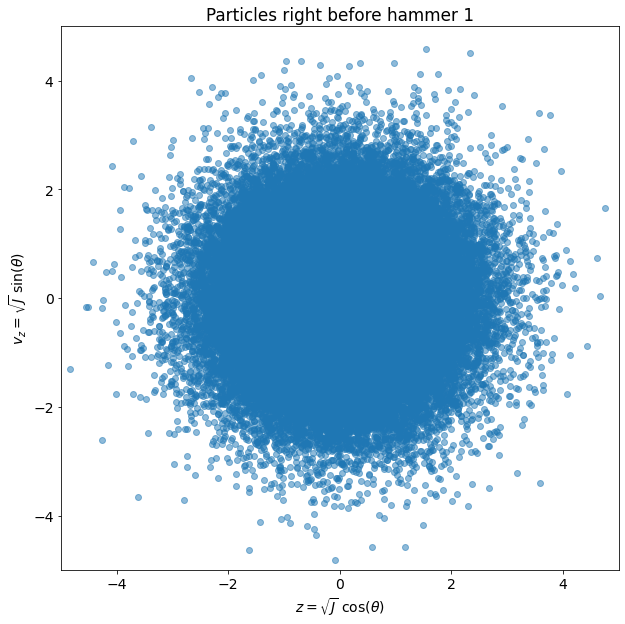

In [26]:
# calculate n_0 and plot initial condition
z_tolerance = 1e-2

fig = plt.figure(figsize=(10,10))
zs, vzs = pol2cart(thetas, Js)
scat = plt.scatter(zs, vzs, alpha=0.5)
# plt.grid()

# number of particles at t=0 within z_tolerance at a z coordinate; this is the
# "background" distribution
z_offset = 1
n_0 = np.sum(np.abs(zs - z_offset) < z_tolerance)
print(f'n_0 = {n_0}')

xlimit = 5
plt.xlim(-xlimit, xlimit)
plt.ylim(-xlimit, xlimit)

plt.xlabel(r"$z = \sqrt{J}$ cos($\theta$)")
plt.ylabel(r"$v_z = \sqrt{J}$ sin($\theta$)")

plt.title('Particles right before hammer 1')

plt.show()

# Animation

t = 0.0
Elapsed t: 0.2 seconds
t = 0.0
Elapsed t: 0.3 seconds
t = 0.0
Elapsed t: 0.3 seconds


<ipython-input-6-87e2c2d79949>:10: RuntimeWarning: invalid value encountered in sqrt
  xs = np.sqrt(Js) * np.cos(thetas)
<ipython-input-6-87e2c2d79949>:11: RuntimeWarning: invalid value encountered in sqrt
  ys = np.sqrt(Js) * np.sin(thetas)
<ipython-input-6-87e2c2d79949>:10: RuntimeWarning: invalid value encountered in sqrt
  xs = np.sqrt(Js) * np.cos(thetas)
<ipython-input-6-87e2c2d79949>:11: RuntimeWarning: invalid value encountered in sqrt
  ys = np.sqrt(Js) * np.sin(thetas)


t = 10.0
Elapsed t: 8.2 seconds
t = 20.0
Elapsed t: 15.8 seconds


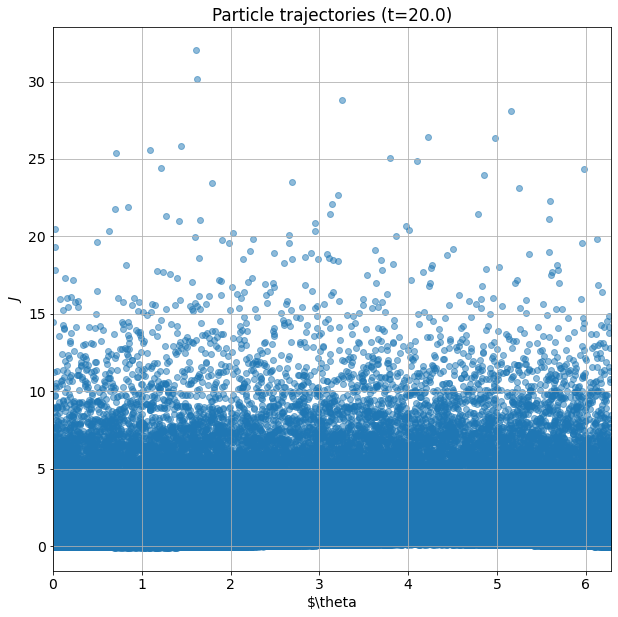

In [33]:
# make the animation
fig = plt.figure(figsize=(10,10))
zs, vzs = pol2cart(thetas, Js)
scat = plt.scatter(thetas, Js, alpha=0.02)

#xlimit = 5
# plt.xlim(-xlimit, xlimit)
# plt.ylim(-xlimit, xlimit)
plt.xlim(0, 2*np.pi)

# plt.xlabel(r"$z = \sqrt{J}$ cos($\theta$)")
# plt.ylabel(r"$v_z = \sqrt{J}$ sin($\theta$)")
plt.xlabel(r"$\theta")
plt.ylabel(r"$J$")

# the "density" at z=0 (in practice, the number of points near z=0) as a function of time
delta_n_over_ns = []

start = time.time()

# simulating pointers with a dictionary... not ideal but we'll see if it works
# source: https://realpython.com/pointers-in-python/#using-python-objects
# WARNING: editing these variables' contents also edits the contents of thetas, Js
variables = {"hammer1_has_hit": False, "hammer2_has_hit": False, \
             "thetas": thetas, "Js": Js, "Omegas": Omegas}

def updatefig(i):
    t = ts[i]
    
    if ((t % 10) == 0):
        print("t = " + str(t))
        print(f'Elapsed t: {np.round(time.time() - start, 1)} seconds')

    # update Js, Omegas iff there's a hammer
    if ((not variables["hammer1_has_hit"]) and (t >= t1)):
        variables["Js"] += n1 * A1 * np.sin(n1 * variables["thetas"])
        variables["Omegas"] = compute_Omega(variables["Js"])
        variables["hammer1_has_hit"] = True
    
    if ((not variables["hammer2_has_hit"]) and (t >= t2)):
        variables["Js"] += n2 * A2 * np.sin(n2 * variables["thetas"])
        variables["Omegas"] = compute_Omega(variables["Js"])
        variables["hammer2_has_hit"] = True
        
    # update thetas
    variables["thetas"] += Omegas * tstep
    variables["thetas"] = np.mod(variables["thetas"], 2*np.pi)
    
#     J_is_negative = (variables["Js"] < 0)
    
#     ## move negative-J particles to J~0 orbits
#     move_negative_J_particles = True
#     if move_negative_J_particles:
#         variables["Js"][J_is_negative] = 0
    
    ## convert coordinates to (z, v_z)
    hide_negative_J_particles = False
    if hide_negative_J_particles:
        zs, vzs = pol2cart(variables["thetas"][~J_is_negative], 
                           variables["Js"][~J_is_negative])
    else:
        zs, vzs = pol2cart(variables["thetas"], 
                           variables["Js"])
    
    ## compute delta n / n_0, ie, number density contrast
    
    # number of particles at t=0 within z_tolerance of our selected z coordinate
#     n_t = np.sum(np.abs(zs - z_offset) < z_tolerance)
#     delta_n_over_n = (n_t - n_0) / n_0
#     delta_n_over_ns.append(delta_n_over_n)
    
    # make plot
    # data = np.transpose((zs, vzs))
    data = np.transpose((variables["thetas"], variables["Js"]))
    scat.set_offsets(data)
    plt.title('Particle trajectories (t=' + str(t) + ')')
    return scat,


make_animation = True
if make_animation:
    ani = animation.FuncAnimation(fig, updatefig, interval=100, frames=len(ts), \
            blit=True)
    ani.save("Sampled_trajectories_temp.mp4")

Source on animating a scatter plot: https://stackoverflow.com/questions/9401658/how-to-animate-a-scatter-plot

t = 0.0
Elapsed t: 0.0 seconds
t = 10.0
Elapsed t: 0.3 seconds
t = 20.0
Elapsed t: 0.6 seconds
t = 30.0
Elapsed t: 0.9 seconds
t = 40.0
Elapsed t: 1.2 seconds
t = 50.0
Elapsed t: 1.5 seconds
t = 60.0
Elapsed t: 1.8 seconds
t = 70.0
Elapsed t: 2.0 seconds
t = 80.0
Elapsed t: 2.3 seconds
t = 90.0
Elapsed t: 2.5 seconds
t = 100.0
Elapsed t: 2.8 seconds
t = 110.0
Elapsed t: 3.2 seconds
t = 120.0
Elapsed t: 3.6 seconds
t = 130.0
Elapsed t: 3.9 seconds
t = 140.0
Elapsed t: 4.3 seconds
t = 150.0
Elapsed t: 4.7 seconds
t = 160.0
Elapsed t: 5.2 seconds
t = 170.0
Elapsed t: 5.5 seconds
t = 180.0
Elapsed t: 5.9 seconds
t = 190.0
Elapsed t: 6.3 seconds
t = 200.0
Elapsed t: 6.6 seconds
t = 210.0
Elapsed t: 7.1 seconds
t = 220.0
Elapsed t: 7.4 seconds
t = 230.0
Elapsed t: 7.8 seconds
t = 240.0
Elapsed t: 8.2 seconds
t = 250.0
Elapsed t: 8.6 seconds
t = 260.0
Elapsed t: 9.0 seconds
t = 270.0
Elapsed t: 9.4 seconds
t = 280.0
Elapsed t: 9.7 seconds
t = 290.0
Elapsed t: 10.1 seconds
t = 300.0
Elapsed t:

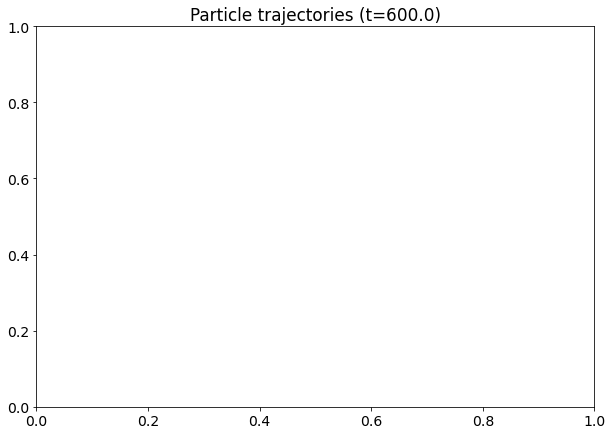

In [14]:
# calculate delta_n_over_ns array, avoiding the animation
start = time.time()
delta_n_over_ns = []

# define a longer time range than in the animation
tmin = 0
tmax = 300
tstep = 0.5
ts = np.arange(tmin, tmax+tstep, tstep)

for i in range(len(ts)):
    updatefig(i)

In [ ]:
plt.plot(ts, delta_n_over_ns)

plt.xlabel('t')
plt.ylabel('$\delta n/n_0$')
plt.title(f'Density contrast at z={z_offset}')

plt.savefig('delta_n_over_ns_temp.png')
plt.show()